# Experiment 1: GDPolyak on a Fourth order Rosenbrock Function

In this experiment, we illustrate GDPolyak algorithm on a Rosenbrock function:

$$f(x, y) = x^4 + (y - x^2)^2$$

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 50 epochs, each consisting of 100 steps, using a constant stepsize of $.125$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration count. 



Running $\mathtt{GDPolyak}$ with $K=100$ and $I=50$
Iteration 1000: loss = 5.7861221154602e-10
Iteration 1000: distance to opt sol = 0.004904524395248813
Iteration 2000: loss = 5.7802385866687174e-15
Iteration 2000: distance to opt sol = 0.0002757315366887018
Iteration 3000: loss = 5.81281478229042e-20
Iteration 3000: distance to opt sol = 1.552732421304554e-05
Iteration 4000: loss = 5.845706241616509e-25
Iteration 4000: distance to opt sol = 8.743981837517187e-07
Iteration 5000: loss = 5.8787842633789175e-30
Iteration 5000: distance to opt sol = 4.924043497946851e-08

Running $\mathtt{{Polyak}}$
Iteration 1000: loss = 2.789366335196447e-11
Iteration 1000: distance to opt sol = 0.0019926103696344
Iteration 2000: loss = 3.1497208814324764e-11
Iteration 2000: distance to opt sol = 0.0012027126264761464
Iteration 3000: loss = 1.033555366664887e-12
Iteration 3000: distance to opt sol = 0.000982957647855667
Iteration 4000: loss = 5.358356532207563e-13
Iteration 4000: distance to opt sol = 

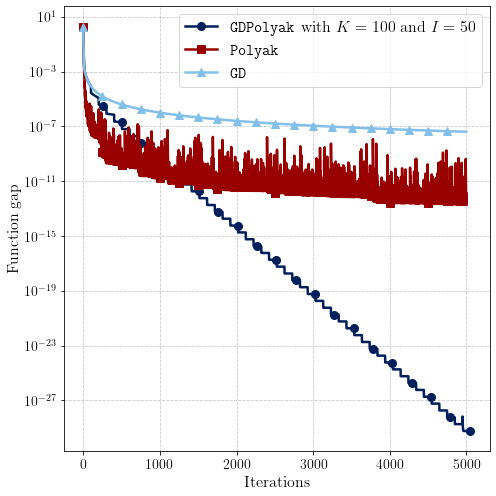

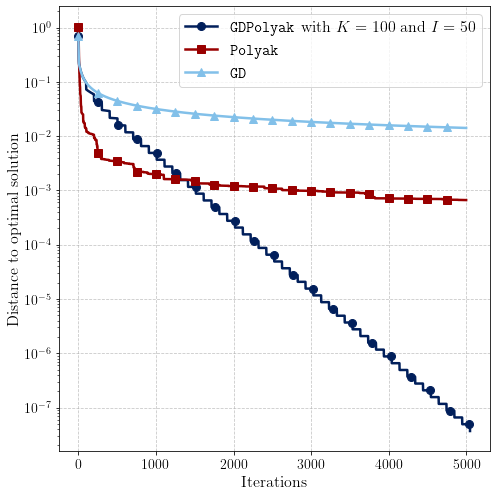

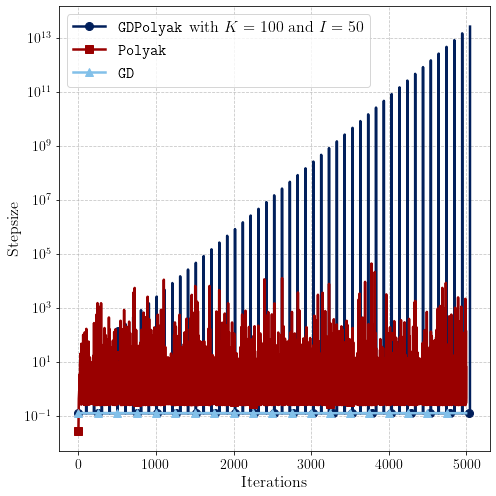

In [1]:
# %%
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.GDPolyak import run_gdpolyak_algorithm
from src.utils import plot_gdpolyak_results

# Define the Rosenbrock function
# f(x,y) = x^4 + (y - x^2)^2
def loss_function():
    return x[0]**4 + (x[1] - x[0]**2)**2

# Define the distance function
def distance_to_opt():
    return torch.norm(x - opt_solution).item()

# Set up experiment parameters
SEED = 3407
K = 100  # Number of GD steps per epoch
I = 50   # Number of epochs
GD_STEP_SIZE = 0.125
NB_RESTARTS = 1

torch.manual_seed(SEED)

# Initialize variables
x = torch.randn(2, requires_grad=True, dtype=torch.double)
initial_x = x.clone()
opt_solution = torch.tensor([0.0, 0.0], requires_grad=True, dtype=torch.double)

# Define experiment cases
cases = [
    {
        "name": f"$\mathtt{{GDPolyak}}$ with $K={K}$ and $I={I}$",
        "nb_GD_steps": K,
        "nb_polyak_steps": I,
        "nb_restarts": NB_RESTARTS,
        "GD_step_size": GD_STEP_SIZE
    },
    {
        "name": "$\mathtt{{Polyak}}$",
        "nb_GD_steps": 0,
        "nb_polyak_steps": K*I,
        "nb_restarts": NB_RESTARTS,
        "GD_step_size": GD_STEP_SIZE
    },
    {
        "name": "$\mathtt{{GD}}$",
        "nb_GD_steps": K*I,
        "nb_polyak_steps": 0,
        "nb_restarts": NB_RESTARTS,
        "GD_step_size": GD_STEP_SIZE
    }
]

# Run each case and store results
results = []
for case in cases:
    print(f"\nRunning {case['name']}")
    # clone the initial x so all algorithms are initialized at the same point
    x = initial_x.clone().detach().requires_grad_(True)
    
    result = run_gdpolyak_algorithm(
        loss_function,
        [x],
        nb_restarts=case['nb_restarts'],
        nb_polyak_steps=case['nb_polyak_steps'],
        nb_gd_steps=case['nb_GD_steps'],
        gd_step_size=case['GD_step_size'],
        opt_est=0,
        distance_func=distance_to_opt,
        print_freq=1000
    )
    
    results.append({
        "name": case['name'],
        "history_loss": result['loss'],
        "history_dist_to_opt_solution": result['dist_to_opt'],
        "step_size_list": result['step_sizes']
    })

# Plot results
plot_gdpolyak_results(results, save_path='./figures/rosenbrock', experiment_name='Rosenbrock')


# Experiment 2: Overparameterized Quadratic Sensing Experiment

In this experiment, we demonstrate the performance of the GDPolyak algorithm on an overparameterized quadratic sensing problem. The task is to recover a low-rank matrix from quadratic measurements, which has applications in various fields such as quantum state tomography, image processing, multi-task regression, and metric embeddings.

In the experiment, we aim to recover a symmetric positive semi-definite matrix $X \in \mathbb{R}^{d\times d}$ with low rank $r \ll d$ from a set of linear measurements $y_i = \langle A_i, X \rangle$, where $A_i \in \mathbb{R}^{d\times d}$ are known matrices. We use a low-rank factorization approach, representing $X = BB^\top$ and optimizing the mean-square-error over the factors:

$$
\min_{B \in \mathbb{R}^{d\times k}} f(B) = \frac{1}{4m} \sum_{i=1}^m (y_i - \langle A_i, BB^\top \rangle)^2
$$

Below, we set the true rank $r = 2$ and the overparameterized rank $k = 4$. The matrix dimension $d = 100$ and the number of measurements $m = 1000$.In addition, each measurement matrix $A_i$ is of the form $A_i = a_i a_i^\top - \tilde{a}_i \tilde{a}_i^\top$, where $a_i$ and $\tilde{a}_i$ are $d$-dimensional standard Gaussian vectors.

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 50 epochs, each consisting of 300 steps, using a constant stepsize of $.05$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration counter. 





Running $\mathtt{GDPolyak}$ with $K=300$ and $I=50$
Iteration 5000: loss = 6.2816518424516314e-12
Iteration 5000: distance to opt sol = 0.00213714597475242
Iteration 10000: loss = 2.0806698592660778e-16
Iteration 10000: distance to opt sol = 0.0001644606593153577
Iteration 15000: loss = 3.303866528557604e-20
Iteration 15000: distance to opt sol = 1.8763598971976428e-05

Running $\mathtt{{Polyak}}$
Iteration 5000: loss = 9.326082114261944e-11
Iteration 5000: distance to opt sol = 0.00430403695823131
Iteration 10000: loss = 1.8714096013680845e-11
Iteration 10000: distance to opt sol = 0.002708310793262059
Iteration 15000: loss = 8.684186954026881e-12
Iteration 15000: distance to opt sol = 0.0019321294982550007

Running $\mathtt{{GD}}$
Iteration 5000: loss = 6.14520490950798e-07
Iteration 5000: distance to opt sol = 0.03683494390737772
Iteration 10000: loss = 1.6611048283028522e-07
Iteration 10000: distance to opt sol = 0.026833140366952606
Iteration 15000: loss = 7.674132988474075e-08
I

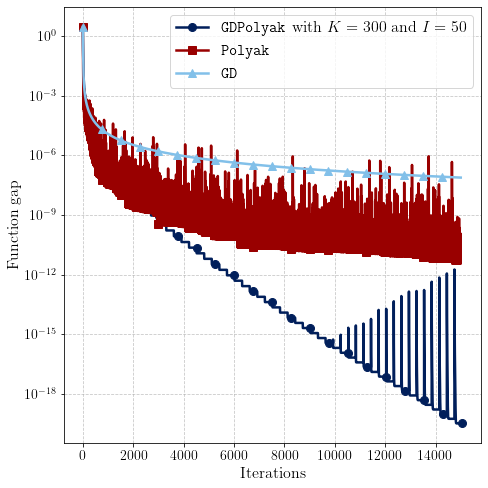

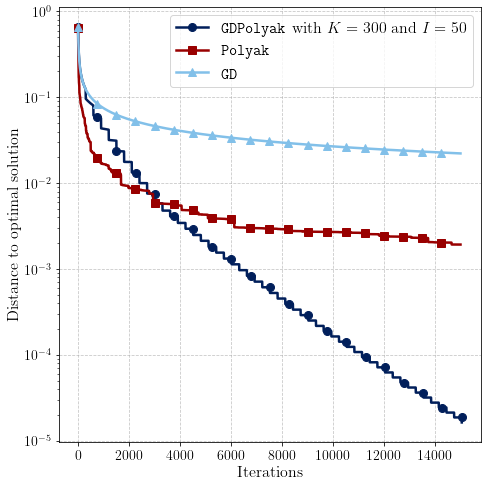

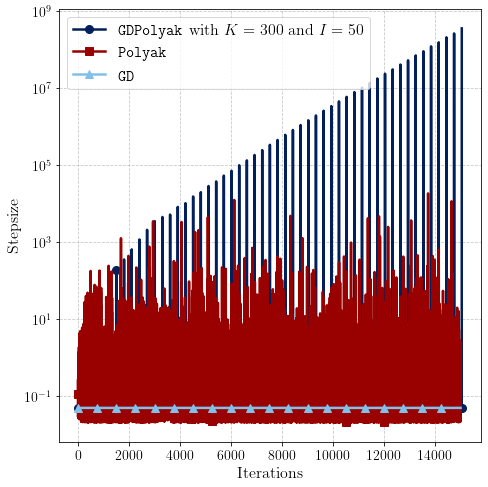

In [2]:
# Import necessary functions and modules
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.GDPolyak import run_gdpolyak_algorithm
from src.utils import plot_gdpolyak_results

# Define the quadratic sensing problem parameters
RANK_SOLUTION = 2
RANK_FACTORIZATION = 4
DIMENSION = 100
NB_MEASUREMENTS = 1000
SEED = 3407

def generate_problem_instance():
    """Generate the problem instance for quadratic sensing."""
    torch.manual_seed(SEED)
    ground_truth = torch.randn(DIMENSION, RANK_SOLUTION, dtype=torch.double)
    ground_truth = ground_truth / ground_truth.norm()
    padded_ground_truth = torch.zeros(DIMENSION, RANK_FACTORIZATION, dtype=torch.double)
    padded_ground_truth[:, :RANK_SOLUTION] = ground_truth
    
    x = torch.randn(RANK_FACTORIZATION * DIMENSION, dtype=torch.double)
    x = x / torch.norm(x)
    x.requires_grad = True
    
    A = torch.randn(NB_MEASUREMENTS, DIMENSION, dtype=torch.double)
    B = torch.randn(NB_MEASUREMENTS, DIMENSION, dtype=torch.double)
    y = torch.sum((A @ padded_ground_truth)**2, dim=1) - torch.sum((B @ padded_ground_truth)**2, dim=1)
    
    return padded_ground_truth, x, A, B, y

def loss_function(x, A, B, y):
    """Compute the loss function for quadratic sensing."""
    x_matrix = x.view(DIMENSION, RANK_FACTORIZATION)
    return F.mse_loss(torch.sum((A @ x_matrix)**2, dim=1) - torch.sum((B @ x_matrix)**2, dim=1), y)

def procrustes_distance(x, ground_truth):
    """Compute the Procrustes distance between x and ground_truth."""
    x_matrix = x.view(DIMENSION, RANK_FACTORIZATION)
    U1, _, V1 = torch.svd(x_matrix)
    U2, _, V2 = torch.svd(ground_truth)
    R = U1 @ U2.t()
    R2 = V2 @ V1.t()
    return torch.norm(x_matrix - R @ ground_truth @ R2, 'fro')

def run_experiment():
    """Run the quadratic sensing experiment."""
    ground_truth, x, A, B, y = generate_problem_instance()
    
    # Set up the optimization parameters for three cases
    K, I = 300, 50
    GD_STEP_SIZE = 0.05
    cases = [
        {
            "name": f"$\\mathtt{{GDPolyak}}$ with $K={K}$ and $I={I}$",
            "nb_GD_steps": K,
            "nb_polyak_steps": I,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": GD_STEP_SIZE
        },
        {
            "name": "$\\mathtt{{Polyak}}$",
            "nb_GD_steps": 0,
            "nb_polyak_steps": K*I,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": GD_STEP_SIZE
        },
        {
            "name": "$\\mathtt{{GD}}$",
            "nb_GD_steps": K*I,
            "nb_polyak_steps": 0,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": GD_STEP_SIZE
        }
    ]
    
    OPT_EST = 0  # The optimal value is 0 for this problem
    results = []
    
    # Clone the initial x so all algorithms are initialized at the same point
    initial_x = x.clone().detach().requires_grad_(True)
    
    # Run the GDPolyak algorithm for each case
    for case in cases:
        print(f"\nRunning {case['name']}")
        # Create a new clone of initial_x for each case
        x = initial_x.clone().detach().requires_grad_(True)
        
        result = run_gdpolyak_algorithm(
            lambda: loss_function(x, A, B, y),
            [x],
            nb_restarts=case['nb_restarts'],
            nb_polyak_steps=case['nb_polyak_steps'],
            nb_gd_steps=case['nb_GD_steps'],
            gd_step_size=case['GD_step_size'],
            opt_est=OPT_EST,
            print_freq=5000,
            distance_func=lambda: procrustes_distance(x, ground_truth)
        )
        results.append({
            'name': case['name'],
            'history_loss': result['loss'],
            'step_size_list': result['step_sizes'],
            'history_dist_to_opt_solution': result['dist_to_opt']
        })
    
    plot_gdpolyak_results(results, save_path='./figures/quadratic_sensing', experiment_name='Quadratic Sensing')

if __name__ == "__main__":
    run_experiment()


# Experiment 3: Learning a Single Neuron in the Overparameterized Regime

In this experiment, we consider the problem of learning a single neuron in the overparameterized regime, as studied by Xu and Du (2023). The objective function for this problem is:

$$
\min_{w}~ f(w) = \mathbb{E}_{x\sim N(0,I)}\left[ \frac{1}{2}\left(\sum_{i=1}^{n}[w_i^\top x]_+ - [v^\top x]_+ \right)^2\right],
$$

where $w = (w_1^\top, w_2^\top,\ldots, w_n^\top)^\top \in \mathbb{R}^{n\times d}$ denotes the parameter vector.

In our experiment, we focus on the simplest overparameterized setting with $n=2$ and $d=100$. Interestingly, the population objective for this problem has an explicit form, which is implemented in the `loss_function()` defined in the code below. This explicit form allows us to directly optimize the population loss without sampling.

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 25 epochs, each consisting of 100 steps, using a constant stepsize of $1.5$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration counter. 




Running $\mathtt{GDPolyak}$ with $K=100$ and $I=25$
Iteration 1000: loss = 4.0063182947842066e-11
Iteration 1000: distance to opt sol = 2.1224051918591905e-06
Iteration 2000: loss = 2.954744547457998e-17
Iteration 2000: distance to opt sol = 1.401068085054115e-10

Running $\mathtt{{Polyak}}$
Iteration 1000: loss = 2.2183614767899124e-11
Iteration 1000: distance to opt sol = 3.902178266421619e-06
Iteration 2000: loss = 1.2843641471747584e-13
Iteration 2000: distance to opt sol = 1.1565625763459717e-07

Running $\mathtt{{GD}}$
Iteration 1000: loss = 5.932471148418752e-08
Iteration 1000: distance to opt sol = 0.0002752915907714608
Iteration 2000: loss = 7.474714176053901e-09
Iteration 2000: distance to opt sol = 6.925749042674914e-05


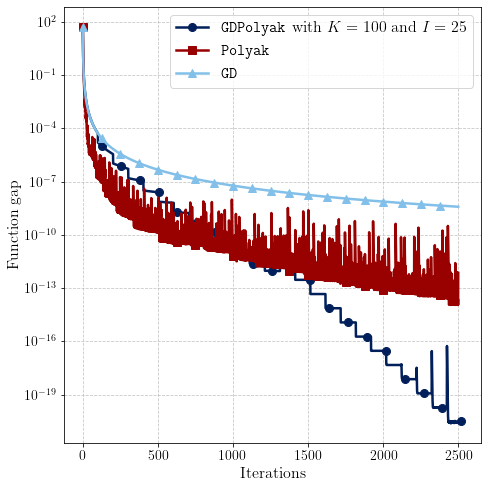

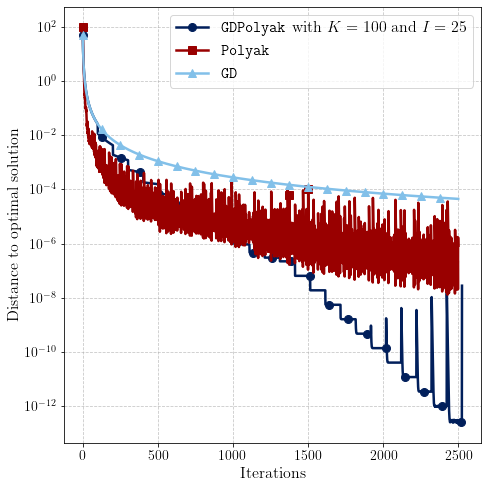

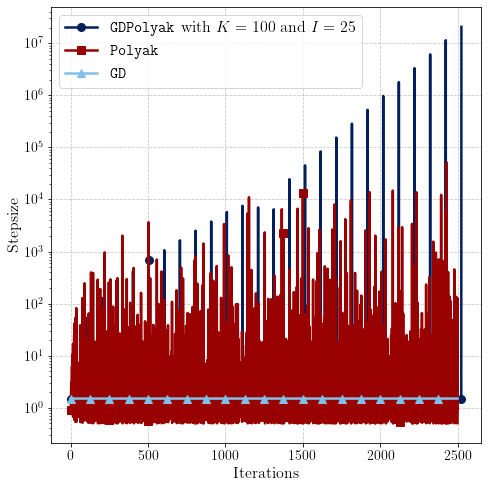

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.GDPolyak import run_gdpolyak_algorithm
from src.utils import plot_gdpolyak_results

# Constants
SEED = 3407
DIMENSION = 100
DTYPE = torch.double

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def initialize_vectors(d):
    return (
        torch.randn(d, requires_grad=True, dtype=DTYPE),
        torch.randn(d, requires_grad=True, dtype=DTYPE),
        torch.randn(d, requires_grad=False, dtype=DTYPE)
    )

def loss_function(w1, w2, v):
    norm_w1, norm_w2, norm_v = map(torch.norm, (w1, w2, v))
    
    cos_theta12 = torch.dot(w1, w2) / (norm_w1 * norm_w2)
    cos_theta1 = torch.dot(w1, v) / (norm_w1 * norm_v)
    cos_theta2 = torch.dot(w2, v) / (norm_w2 * norm_v)

    sin_theta12, sin_theta1, sin_theta2 = map(lambda x: torch.sqrt(1 - x**2), (cos_theta12, cos_theta1, cos_theta2))
    
    term1 = 0.25 * torch.norm(w1 + w2 - v)**2
    term2 = (1 / (2 * np.pi)) * (sin_theta12 - torch.acos(cos_theta12) * cos_theta12) * norm_w1 * norm_w2
    term3 = (1 / (2 * np.pi)) * sum((sin_theta - torch.acos(cos_theta) * cos_theta) * norm_w * norm_v 
                                    for sin_theta, cos_theta, norm_w in zip([sin_theta1, sin_theta2], [cos_theta1, cos_theta2], [norm_w1, norm_w2]))

    return term1 + term2 - term3

@torch.no_grad()
def distance_to_opt(w1, w2, v):
    norm_diff = torch.norm(w1 + w2 - v)
    norm_v, norm_w1, norm_w2 = map(torch.norm, (v, w1, w2))
    
    abs_diffs = [torch.abs(torch.dot(w, v) - norm_w * norm_v) for w, norm_w in zip([w1, w2], [norm_w1, norm_w2])]
    max_norm_diffs = [torch.max(torch.tensor(0.0, dtype=DTYPE), norm_w - 2 * norm_v) for norm_w in [norm_w1, norm_w2]]
    max_norm_fractions = [torch.max(torch.tensor(0.0, dtype=DTYPE), norm_v / 8 - norm_w) for norm_w in [norm_w1, norm_w2]]
    
    return sum([norm_diff] + abs_diffs + max_norm_diffs + max_norm_fractions).item()

def run_experiment():
    K = 100
    I = 25
    set_seed(SEED)
    w1, w2, v = initialize_vectors(DIMENSION)
    initial_w1 = w1.clone()
    initial_w2 = w2.clone()
    cases = [
        {
            "name": f"$\\mathtt{{GDPolyak}}$ with $K={K}$ and $I={I}$",
            "nb_GD_steps": K,
            "nb_polyak_steps": I,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": 1.5
        },
        {
            "name": "$\\mathtt{{Polyak}}$",
            "nb_GD_steps": 0,
            "nb_polyak_steps": K*I,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": 1.5
        },
        {
            "name": "$\\mathtt{{GD}}$",
            "nb_GD_steps": K*I,
            "nb_polyak_steps": 0,
            "nb_restarts": NB_RESTARTS,
            "GD_step_size": 1.5
        }
    ]

    results = []
    for case in cases:
        print(f"\nRunning {case['name']}")
        # all algorrithms are initialized at the same point which is a clone of the initial vector
        w1 = initial_w1.clone().detach().requires_grad_(True)
        w2 = initial_w2.clone().detach().requires_grad_(True)

                
        result = run_gdpolyak_algorithm(
            lambda: loss_function(w1, w2, v),
            [w1, w2],
            nb_restarts=case['nb_restarts'],
            nb_polyak_steps=case['nb_polyak_steps'],
            nb_gd_steps=case['nb_GD_steps'],
            gd_step_size=case['GD_step_size'],
            opt_est=0,
            distance_func=lambda: distance_to_opt(w1, w2, v),
            print_freq=1000
        )
        
        results.append({
            "name": case['name'],
            "history_loss": result['loss'],
            "history_dist_to_opt_solution": result['dist_to_opt'],
            "step_size_list": result['step_sizes']
        })

    plot_gdpolyak_results(results, save_path='./figures/neural_network', experiment_name='Neural Network')

if __name__ == "__main__":
    run_experiment()
